In [22]:
import librosa
import IPython.display as ipd #to visualize the sound data
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

[-1.0710210e-08 -5.1222742e-09 -6.5192580e-09 ...  1.8561386e-02
  2.6891200e-02  3.4412310e-02]


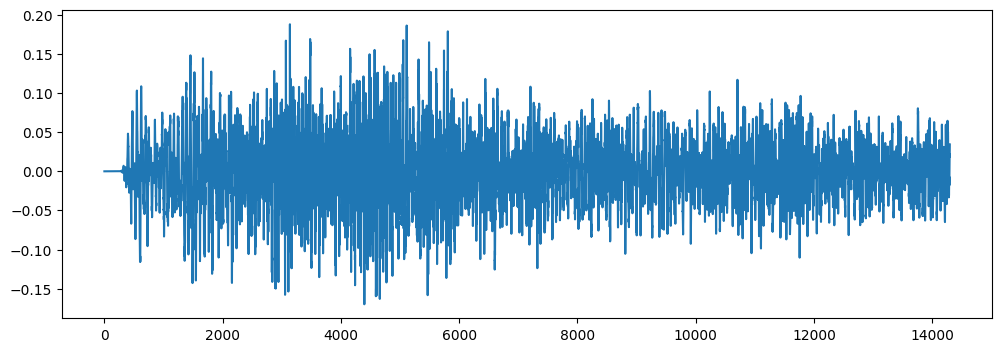

In [2]:
filename='/kaggle/input/urbansound8k/fold10/100648-1-0-0.wav'  # select a random one
data,sample_rate=librosa.load(filename)
ipd.Audio(filename)
librosa_audio_data,librosa_sample_rate=librosa.load(filename)
print(librosa_audio_data)
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [3]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients

audio_dataset_path='/kaggle/input/urbansound8k'
extracted_features=[]
metadata = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    final_class_labels=row["class"]
    
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])
    
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

3555it [02:11, 27.86it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [04:55, 41.26it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [05:08, 28.29it/s]


,feature,class
0,"[-211.93698, 62.581215, -122.81315, -60.745293...",dog_bark
1,"[-417.00516, 99.336624, -42.995583, 51.073326,...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63867, 103.86224, -42.658783, 50.690285,...",children_playing


In [21]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())


In [24]:
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in kf.split(X, y_encoded):
    print(f"\n Training Fold {fold}")

    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # Reshape for LSTM input
    X_train = X_train.reshape(-1, 40, 1)
    X_val = X_val.reshape(-1, 40, 1)

    # Define model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(40,1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ModelCheckpoint(f'model_fold{fold}.keras', monitor='val_loss', save_best_only=True)
    ]

    # Train
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=80,
                        batch_size=32,
                        callbacks=callbacks,
                        verbose=1)

    # Evaluate
    score = model.evaluate(X_val, y_val, verbose=0)
    print(f" Fold {fold} Accuracy: {score[1]:.4f}")
    fold += 1



 Training Fold 1
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2082 - loss: 2.1318 - val_accuracy: 0.4259 - val_loss: 1.6398
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4030 - loss: 1.6750 - val_accuracy: 0.4871 - val_loss: 1.4241
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4397 - loss: 1.5576 - val_accuracy: 0.5449 - val_loss: 1.2835
Epoch 4/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5074 - loss: 1.4205 - val_accuracy: 0.6005 - val_loss: 1.1867
Epoch 5/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5328 - loss: 1.3451 - val_accuracy: 0.6073 - val_loss: 1.1208
Epoch 6/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5742 - loss: 1.2582 - val_accuracy: 0.6548 - val_loss: 1.0470
Epoch 7/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5881 - loss: 1.2017 - val_accuracy: 0.6594 - val_loss: 0.9979
Epoch 8/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5958 - loss: 1.1704 - val_accuracy: 0.6800 - val_

In [27]:
# Convert one-hot test labels to integer class indices
y_test_int = np.argmax(y_test, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_test_int, verbose=0)

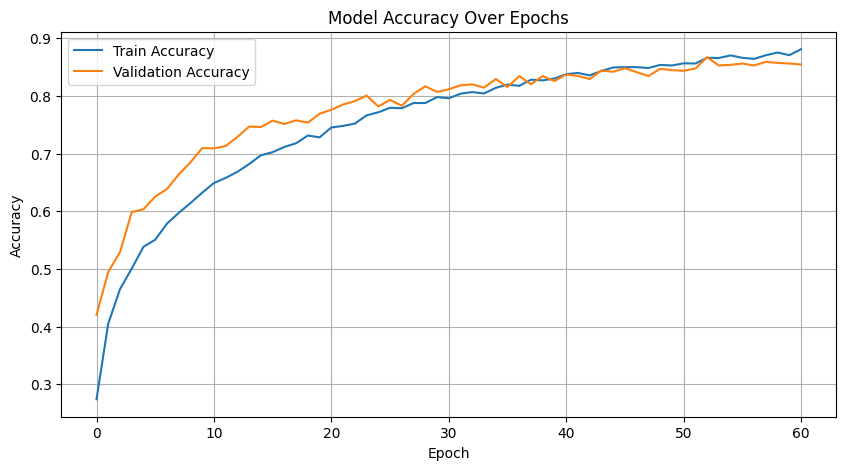

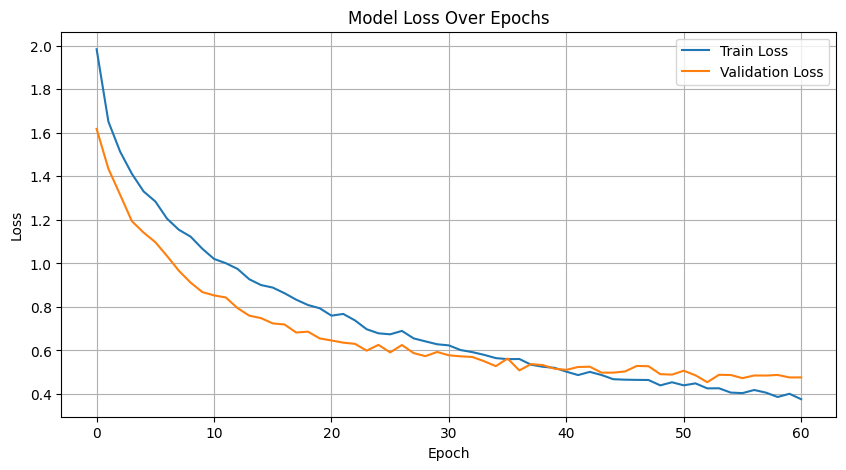

In [28]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
